# Data Augumentation
La data augmentation è un passaggio fondamentale quando si addestrare un modello, soprattutto quando si trattano dei dataset ridotti. Noi non andremo a aumentare la grandezza del dataset, ma andremo a modificare gli audio così da analizzare come performa il modello. 

Nel nostro caso, pur utilizzando dei livelli convolutivi, non è possibile replicare la stessa data augmentation delle immagini. E' vero che stiamo utilizzando degli spettrogrammi che tra l'altro mostriamo come immagine, ma non sono la stessa cosa; siamo in grado di mostrarli come immagini soltanto perché sono una matrice, e come spiegato in precedenza la matrice dello spettrogramma rappresentano l'ampiezza e la fase dell'audio, che non sono paragonabili ai valori di un'immagine.

La data augmentation per noi è il fulcro del nostro progetto, perchè qui risiede la nostra idea innovativa. Abbiamo preso un dataset formato da 10 audio di rumori ambientali differenti, e li applicheremo ai nostri audio originali.

In [271]:
import tensorflow as tf
import numpy as np
import librosa
import IPython.display as IPD
from IPython.display import Audio
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import random
import wave

import pandas as pd

## Importazione dei dataset
Importiamo tutti i dataset contenenti gli audio necessari. Oltre al train_ds e validation_ds importiamo anche il nostro nuovo dataset contenente gli audio rumorosi.

In [200]:
train_ds, validation_ds = tf.keras.utils.audio_dataset_from_directory(
    directory ='../reduced_dataset/dataset/audio',
    validation_split=0.4, # stiamo mettendo da parte il 40% del dataset, che sarà suddiviso in validation set e test set
    shuffle=True,
    subset='both', # necessario se stiamo utilizzando validation_split (se no darebbe errore)
    seed=0, # necessario se stiamo utilizzando sia shuffle che validation_split (se no darebbe errore)
    batch_size=32
)
audio_label_names = train_ds.class_names

noise_ds = tf.keras.utils.audio_dataset_from_directory(
    directory='../noise_dataset',
    batch_size = 1
)

noise_label_names = noise_ds.class_names

Found 12933 files belonging to 30 classes.
Using 7760 files for training.
Using 5173 files for validation.
Found 14 files belonging to 14 classes.


## Differenza tra rumore e audio 
Gli audio rumorosi che stiamo usando sono tutti di lunghezze e sampling rate differenti. Abbiamo perciò fatto questo questo e quest'altro. Andrea ti voglio bene, riscrivilo benissimo come sai fare tu.

In [416]:
def show_audio_length(dataset, df_seconds):   
    fig, ax = plt.subplots(figsize=(14, 6))

    df = pd.read_csv(df_seconds)
    
    labels = []
    audios = []

    label_names = dataset.class_names
    
    for audio, label in dataset:
        labels.appendlabel_names[int(label)])
        mask = df["label"].isin([label_names[int(label)]])
        
        audios.append(int(df.loc[mask, "seconds"].iloc[0]))
    
    ax.barh(labels, audios, color='rosybrown')

    ax.set_ylabel("Classi", fontweight="semibold", fontsize=12, labelpad=10)
    ax.set_xlabel("Lunghezza audio (secondi)", fontweight="semibold", fontsize=12, labelpad=20)
    ax.set_title("Distribuzione lunghezze audio rumorosi")
    ax.set_xticks(range(0, 310, 10))
    
    # nascondo bordi plot
    ax.spines["left"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    ax.grid(True, color="gainsboro", linestyle="--", alpha=0.2)
        
    plt.show()

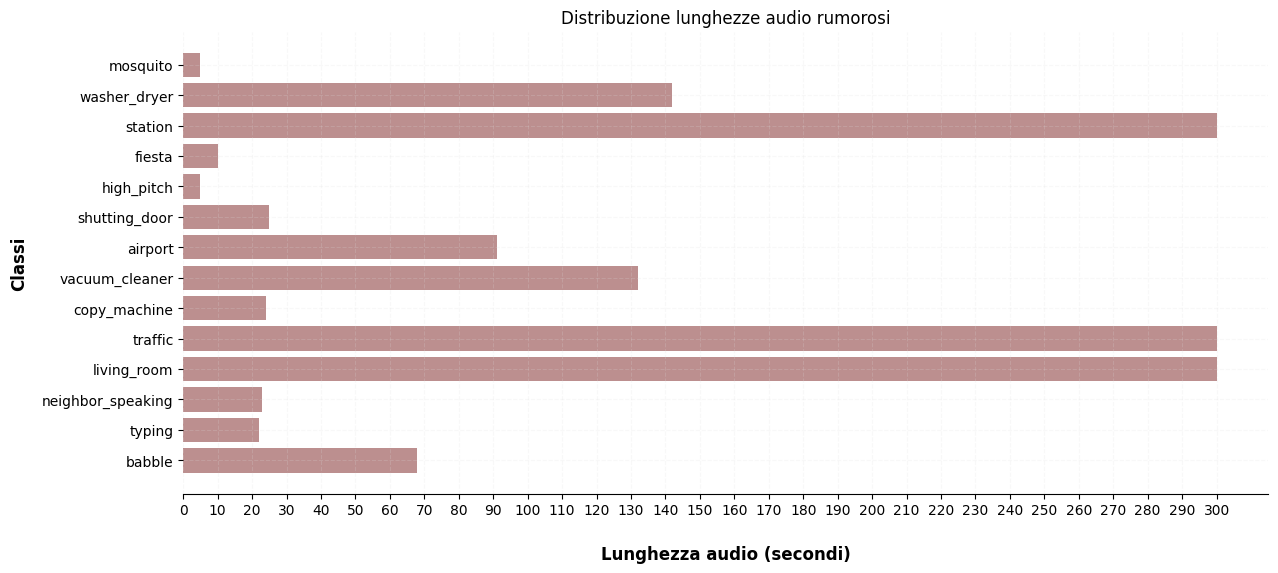

In [417]:
show_audio_length(noise_ds, "../noise_dataset.csv")

In [9]:
def samplefy(dataset, dir_label, search="audio"):
    for audio, label in dataset: # iteriamo all'interno del dataset
        label_np = label.numpy() 
        
        for i in range(len(label_np)): # controlliamo per ogni label se è uguale a quella richiesta
            if search == "audio" and (audio_label_names[label_np[i]] == dir_label):
                return audio[i], audio_label_names[label_np[i]] # ci restituisce il campione con la sua etichetta
            
            if search == "noise" and (noise_label_names[label_np[i]] == dir_label):
                return audio[i], noise_label_names[label_np[i]]

In [10]:
def plot_waves(dataset_audio, label_audio, dataset_noise, label_noise):
    audio, label_audio = samplefy(train_ds, label_audio)
    noise, label_noise = samplefy(noise_ds, label_noise, search="noise")
    
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))  # aumenta la dimensione della figura
    fig.tight_layout(pad=3.0)  # aggiungi padding tra i subplot

    # audio normale
    # label e titolo
    ax[0].set_title('Classe audio: ' + label_audio)
    ax[0].set_ylabel('Ampiezza')
    ax[0].set_xlabel('Frame')
    # rimuoviamo i limiti dei plot
    ax[0].spines["right"].set_visible(False)
    ax[0].spines["top"].set_visible(False)
    ax[0].spines["left"].set_visible(False)
    # griglia
    ax[0].grid(True, color="gainsboro", linestyle="--", alpha=0.5)
    ax[0].plot(audio, color="indianred", alpha=0.9)
    
    # audio noise
    # label e titolo
    ax[1].set_title('Classe audio rumoroso: ' + label_noise)
    ax[1].set_ylabel('Ampiezza')
    ax[1].set_xlabel('Frame')
    # rimuoviamo i limiti dei plot
    ax[1].spines["right"].set_visible(False)
    ax[1].spines["top"].set_visible(False)
    ax[1].spines["left"].set_visible(False)
    # griglia
    ax[1].grid(True, color="gainsboro", linestyle="--", alpha=0.5)
    ax[1].plot(noise, color="indianred", alpha=0.5)
    # mostriamo la differenza di lunghezza
    min_value_noise = tf.reduce_min(noise) # computo il minimo
    max_value_noise = tf.reduce_max(noise) # computo il massimo

    pos_rect = np.random.randint(0, len(noise) - 16000)
    
    grandezza_audio = mpatches.Rectangle((pos_rect, min_value_noise.numpy()), 
                                         width=16000, height=max_value_noise.numpy() + np.abs(min_value_noise.numpy()), 
                                         color='burlywood', alpha=0.95)
    ax[1].add_patch(grandezza_audio)
    
    plt.show()

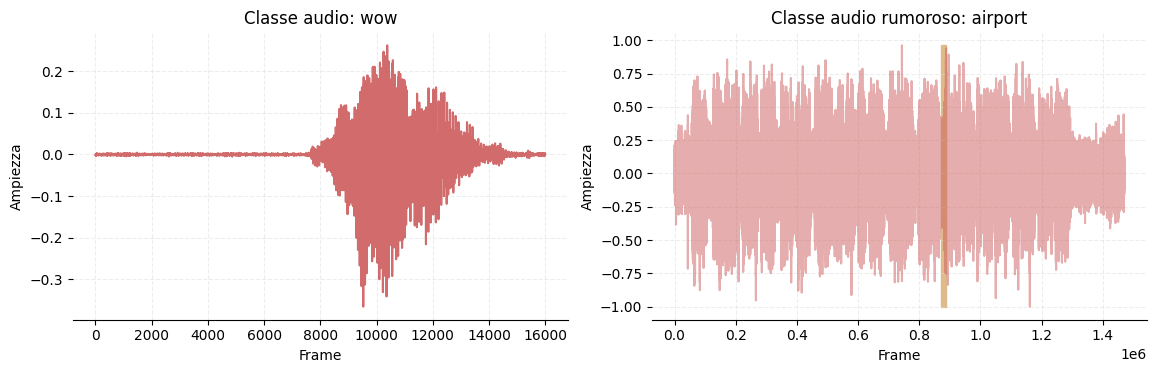

In [12]:
plot_waves(train_ds, "wow", noise_ds, "airport")

Come possiamo notare la lunghezza degli audio rumorosi è molto più lunga rispetto a quella dei nostri audio normali. Il rettangolo nel grafico dell'audio rumoroso definisce la parte di audio che corrisponde a 16000 di lunghezza, che possiamo notare essere molto minore rispetto alla lunghezza totale di **518400**.

## Taglio degli audio rumorosi
Come abbiamo visto in precedenza gli audio rumorosi e gli audio normali hanno lunghezze diverse. Perciò procediamo a tagliare gli audio rumorosi ad una lunghezza di un secondo. 

In [18]:
new_noise_audios = [] # inizializziamo una lista dove inseriremo i nostri noise tagliati

# iteriamo nel dataset con gli audio rumorosi
for noise, label in noise_ds:
    # tagliamo l'audio ad un secondo e lo appendiamo a una lista 
    noise = tf.reshape(noise, [-1])[600:16600]
    new_noise_audios.append(noise.numpy()) # convertiamo in array per poterli modificare
    
test_noise_audio = new_noise_audios[0].astype(np.float32)
print(np.shape(new_noise_audios))

(14, 16000)


In [19]:
print(len(new_noise_audios))

14


In [20]:
for noise in new_noise_audios: # iteriamo la lista contenente i noise tagliati e li ascoltiamo
    display(Audio(noise, rate=16000))

In [10]:
rows = 5
cols = 2

labels = new_noise_audios(noise.keys()) # mi salvo la lista delle label
# Plottiamo tutti i noise
fig, axes = plt.subplots(rows, cols, figsize=(12, 18))  # aumenta la dimensione della figura
fig.tight_layout(pad=3.0)  # aggiungi padding tra i subplot

for index, noise in enumerate(new_noise_audios):
    row = index // cols
    col = index % cols

    ax = axes[row][col]
    
    ax.set_ylabel('Ampiezza', fontweight="bold")
    ax.set_xlabel('# frame', fontweight="bold")
    ax.set_title(str(labels[index]))
    ax.plot(noise, color="indianred")
    
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'keys'

## Unione del rumore ai nostri file audio
Ora che abbiamo la nostra lista di audio rumorosi con la lunghezza giusta possiamo procedere alla sovrapposizione del rumore.

In [11]:
mixed_dataset = [] # inizializziamo la lista dove inseriremo gli audio uniti al rumore

counter = 0

train_ds = train_ds.unbatch()
labels_np = np.array([label.numpy() for _, label in train_ds])

for audio, label in train_ds:    
    audio = np.squeeze(audio, axis=-1)
    
    # Scegliamo in modo randomico un audio dalla lista ri
    noise_sample = random.choice(new_noise_audios)

    mixed_audio = audio + noise_sample # mo00ltiplichiamo per un valore costante molto piccoli cosi da ridurre il volume del rumore e far sentire meglio l'audio del comando
        
    # appendiamo alla lista mixed dataset
    mixed_dataset.append((mixed_audio, label))

# trasformiamo la lista mixed_dataset in un dataset da poter passare ai modelli
# mixed_dataset = tf.data.Dataset.from_tensor_slices(mixed_dataset)

In [12]:
print(mixed_dataset[0])

(array([-0.05172729, -0.05090332, -0.04968262, ...,  0.02740479,
        0.02926636,  0.03045654], dtype=float32), <tf.Tensor: shape=(), dtype=int32, numpy=18>)


In [13]:
audio_data = [tf.convert_to_tensor(audio, dtype=tf.float32) for audio, label in mixed_dataset]
labels = [label for _, label in mixed_dataset]

In [14]:
mixed_dataset = tf.data.Dataset.from_tensor_slices((audio_data, labels))

In [19]:
counter = 0

for audio, label in mixed_dataset:
    display(Audio(audio, rate=16000))

    if counter == 10:
        break

    counter += 1

